In [1]:
# PROJECT : STOCK MARKET FORECASTING USING TIME SERIES ANALYSIS & ARIMA MODEL 
# first import important libraries 

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('nifty50.csv')
# stock_data = stock_data[:3000]
# stock_data
# print(stock_data(5,2))
stock_data.loc[0].at["date"]
new_stock_data = stock_data.drop_duplicates(subset=['date'], keep='first')
# stock_data.drop_duplicates()
# for i in range(len(new_stock_data.index)):
#     a = str(new_stock_data.loc[i].at["date"])
#     date = a[6:8]
#     month = a[5:7]
#     year = a[:5]
#     new_stock_data.loc[i].at["date"] = date+month+year
# new_stock_data['date'] = new_stock_data.to_datetime(new_stock_data['date'])
new_stock_data['date'] = pd.to_datetime(new_stock_data['date'], format='%Y%m%d').dt.strftime("%d%m%Y") 
new_stock_data


,index,date,time,open,high,low,close
0,NIFTY,01042013,09:16,5701.15,5704.65,5694.30,5697.00
375,NIFTY,02042013,09:16,5703.05,5703.10,5691.45,5692.80
750,NIFTY,03042013,09:16,5741.40,5743.85,5727.60,5730.20
1125,NIFTY,04042013,09:16,5642.20,5643.45,5633.85,5639.75
1500,NIFTY,05042013,09:16,5574.40,5574.40,5561.85,5563.20
...,...,...,...,...,...,...,...
351045,NIFTY,26092016,09:16,8809.15,8809.55,8784.65,8786.85
351420,NIFTY,27092016,09:16,8752.10,8762.40,8748.35,8762.05
351795,NIFTY,28092016,09:16,8713.25,8728.00,8707.60,8718.80
352170,NIFTY,29092016,09:16,8790.15,8800.65,8787.45,8793.40


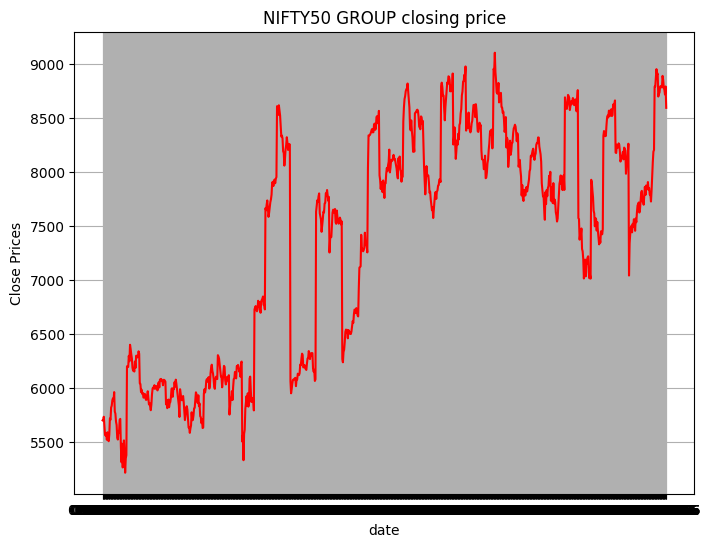

In [3]:
# visualize the stock's daily nifty50 price
plt.figure(figsize=(8,6))
plt.grid(True)
plt.xlabel('date')
plt.ylabel('Close Prices')
plt.plot(new_stock_data['date'] , new_stock_data['close'] , c = 'red')
plt.title('NIFTY50 GROUP closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

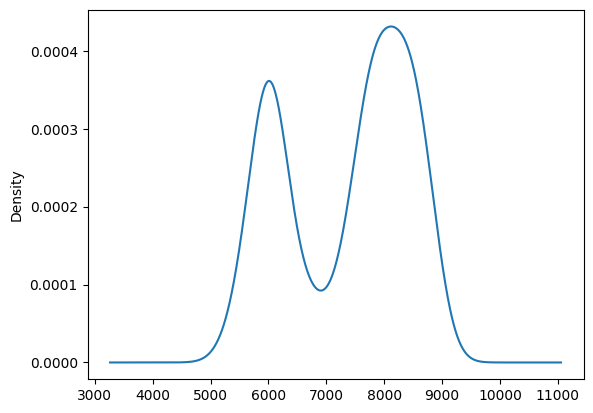

In [4]:
#Distribution of the dataset
df_close = new_stock_data['close']
df_close.plot(kind='kde')

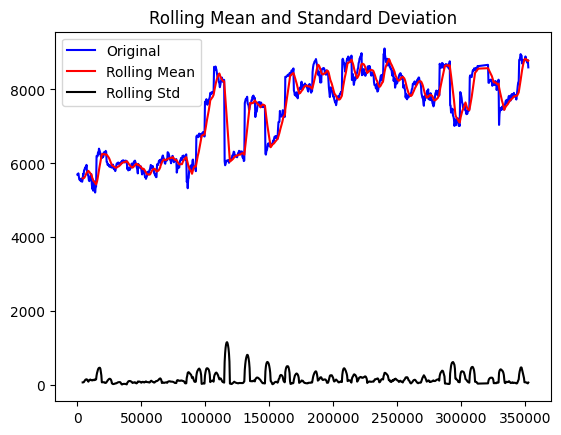

Results of dickey fuller test
Test Statistics                 -2.564586
p-value                          0.100540
No. of lags used                 0.000000
Number of observations used    924.000000
critical value (1%)             -3.437447
critical value (5%)             -2.864673
critical value (10%)            -2.568438
dtype: float64


In [5]:
# time series = trend , seasonality and statonarity 
# for checking weather the series / data is stationary or not we apply ad fuller test (augmented dickey- fuller test)

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)


or we can use this code 


In [6]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(new_stock_data['close'] , autolag = 'AIC')

print("1. ADF : ",dftest[0])          # adf test  
print("2. P-value :", dftest[1])    # p-value 
print("3. num of lags :", dftest[2])    # find no. of lags 
print("4. num of observation used for ADF regression and critical values calculation :", dftest[3])
print("5. critical values :")
for key, val in dftest[4].items():
    print("\t",key,":", val)

1. ADF :  -2.5645859875369283
2. P-value : 0.10053972216042895
3. num of lags : 0
4. num of observation used for ADF regression and critical values calculation : 924
5. critical values :
	 1% : -3.437446926086526
	 5% : -2.8646730402041443
	 10% : -2.568438225155076


Let’s isolate the time series from the Trend and Seasonality.

<Figure size 640x480 with 0 Axes>

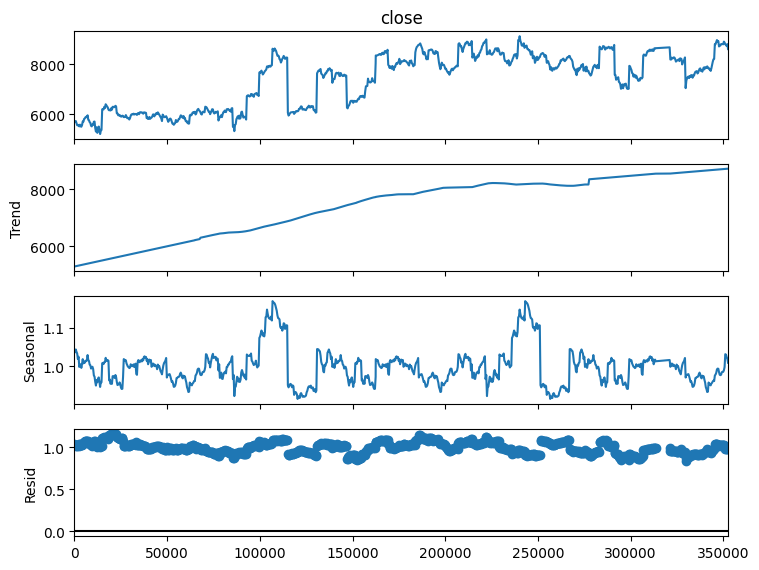

In [7]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', extrapolate_trend='freq', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8,6)
plt.show()



No handles with labels found to put in legend.


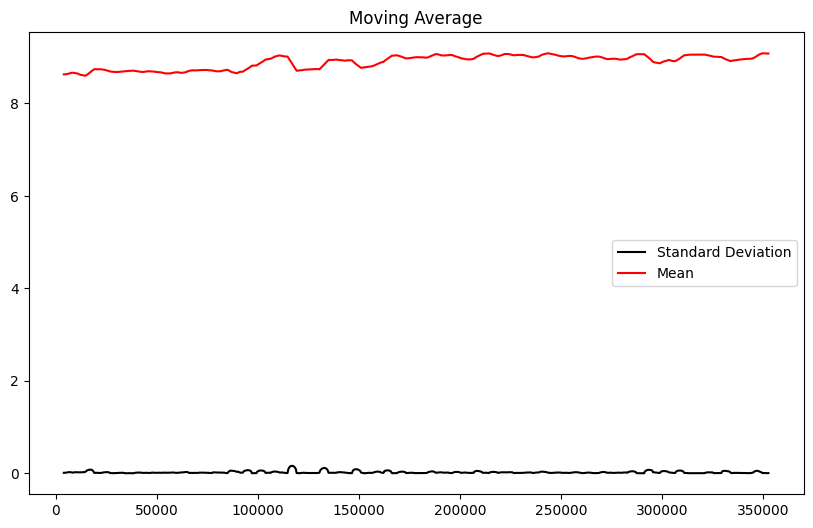

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

let’s visualize the data by dividing it into training and test sets.

1125      8.637595
1500      8.623929
1875      8.622508
2250      8.626577
2625      8.615608
            ...   
309045    9.047968
309420    9.050612
309795    9.048498
310170    9.055895
310545    9.055895
Name: close, Length: 829, dtype: float64
310920    9.050301
311295    9.053874
311670    9.057469
312045    9.050066
312420    9.051122
            ...   
351045    9.081012
351420    9.078185
351795    9.073237
352170    9.081757
352545    9.058965
Name: close, Length: 93, dtype: float64


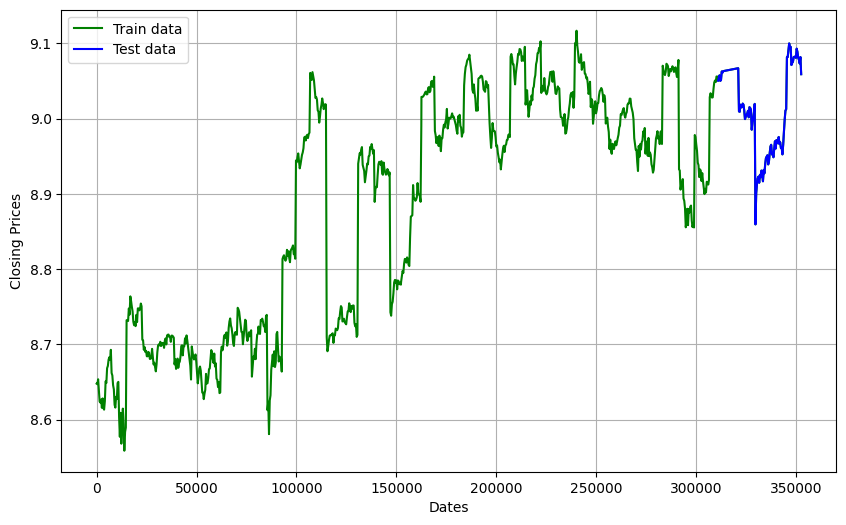

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
print(train_data)
print(test_data)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5975.619, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3799.345, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3793.564, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3809.425, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1721.425, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3811.302, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-758.309, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3809.474, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3807.486, Time

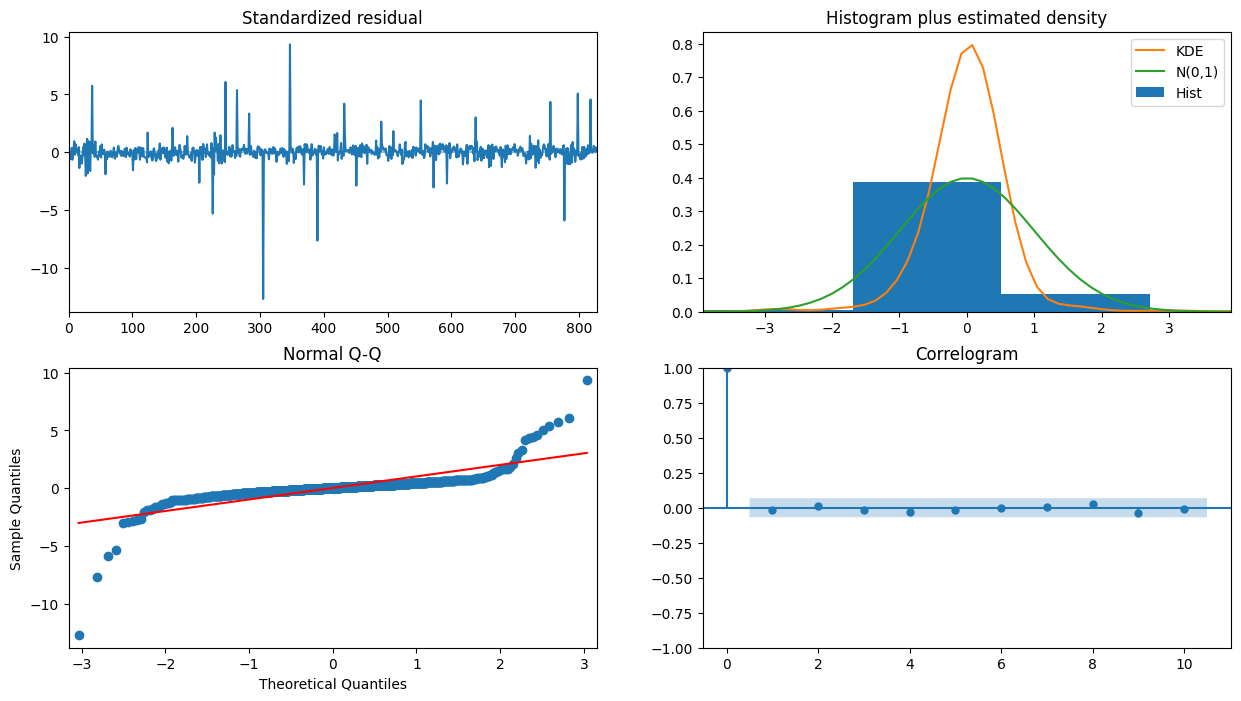

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
# #Modeling
# # Build Model
# model = ARIMA(train_data, order=(2,1,0))  
# fitted = model.fit(disp=-1)  
# print(fitted.summary())
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,0,0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1908.647
Date:                Sun, 11 Jun 2023   AIC                          -3811.294
Time:                        14:13:12   BIC                          -3797.133
Sample:                             0   HQIC                         -3805.863
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8802      0.056    158.388      0.000       8.770       8.990
ar.L1          0.9867      0.007    149.334      0.000       0.974       1.000
sigma2         0.0006   7.03e-06     82.920      0.0

C:\Users\PARUL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PARUL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PARUL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


829    9.053560
830    9.051257
831    9.048984
832    9.046742
833    9.044529
         ...   
917    8.933617
918    8.932907
919    8.932206
920    8.931515
921    8.930833
Name: predicted_mean, Length: 93, dtype: float64
310920   NaN
311295   NaN
311670   NaN
312045   NaN
312420   NaN
          ..
351045   NaN
351420   NaN
351795   NaN
352170   NaN
352545   NaN
Name: predicted_mean, Length: 93, dtype: float64


C:\Users\PARUL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


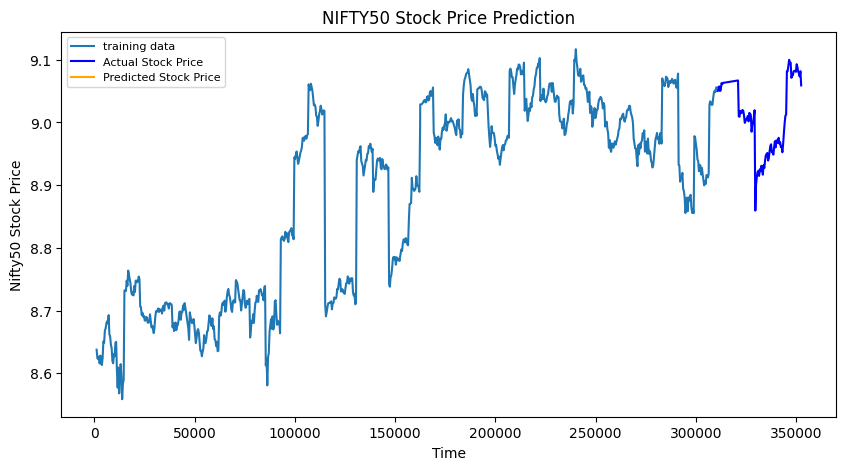

In [12]:
# Forecast
fc= fitted.forecast(93, alpha=0.05) # 95% conf  93 = no of row of test_data
# fc,se, conf = fitted.forecast(93, alpha=0.05), fitted.forecast(93, alpha=0.05), fitted.forecast(93, alpha=0.05)
print(fc)
# Make as pandas series
fc_series = pd.Series(data=fc, index=test_data.index)
print(fc_series)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('NIFTY50 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty50 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.005525134278631209
MAE: 0.05079196797766478
RMSE: 0.07433124698692475
MAPE: nan
